# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></div><div class="lev1 toc-item"><a href="#Cross-validation" data-toc-modified-id="Cross-validation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Cross-validation</a></div><div class="lev1 toc-item"><a href="#K-fold-cross-validation" data-toc-modified-id="K-fold-cross-validation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>K-fold cross-validation</a></div>

# Setup

First we'll load some packages, including the recent `modelr` for easy modeling, setting options to warn us whenever observations with missing values are ignored by our models.

In [50]:
RNGkind(sample.kind = "Rounding")
library(tidyverse)
library(scales)
library(modelr)

theme_set(theme_bw())
options(repr.plot.width=4, repr.plot.height=3)

Warning message in RNGkind(sample.kind = "Rounding"):
"non-uniform 'Rounding' sampler used"

Then we'll load a data frame of the number of total trips taken by Citibike riders for each day in 2014, along with the weather on each day.

In [51]:
trips_per_day <- read_tsv('trips_per_day.tsv')
head(trips_per_day)

Parsed with column specification:
cols(
  ymd = col_date(format = ""),
  num_trips = col_double(),
  date = col_double(),
  prcp = col_double(),
  snwd = col_double(),
  snow = col_double(),
  tmax = col_double(),
  tmin = col_double()
)


ymd,num_trips,date,prcp,snwd,snow,tmax,tmin
2014-01-01,6059,20140101,0.00,0.0,0.0,3.3,2.4
2014-01-02,8600,20140102,0.33,0.0,3.1,3.3,1.8
2014-01-03,1144,20140103,0.29,5.9,3.3,1.8,0.9
2014-01-04,2292,20140104,0.00,5.9,0.0,2.9,0.8
2014-01-05,2678,20140105,0.14,3.9,0.0,4.0,2.7
2014-01-06,9510,20140106,0.36,1.2,0.0,5.5,1.9


Let's plot the number of trips taken as a function of the minimum temperature on each day.

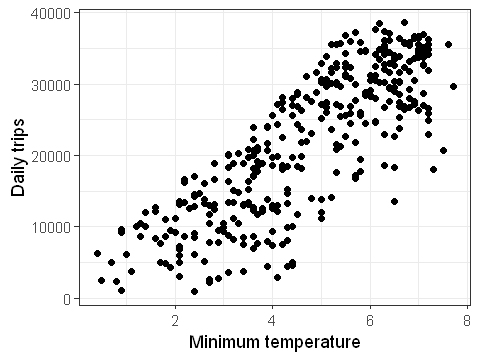

In [52]:
ggplot(trips_per_day, aes(x = tmin, y = num_trips)) +
  geom_point() +
  xlab('Minimum temperature') +
  ylab('Daily trips') +
  scale_y_continuous()

# Cross-validation

Now we'll try fitting different polynomials to this data, and use cross-validation to find the polynomial degree that generalizes best to held out data.

First we'll shuffle the data and make an 80% train and 20% validation split.

In [53]:

set.seed(42)

num_days <- nrow(trips_per_day)
frac_train <- 0.8
num_train <- floor(num_days * frac_train)

# randomly sample rows for the training set 
ndx <- sample(1:num_days, num_train, replace=F)

# used to fit the model
trips_per_day_train <- trips_per_day[ndx, ]

# used to evaluate the fit
trips_per_day_validate <- trips_per_day[-ndx, ]

Now we'll evaluate models from degree 1 up through degree 8.
For each we'll fit on the training data and evaluate on the validation data.

In [54]:
# fit a model for each polynomial degree
K <- 1:8
train_err <- c()
validate_err <- c()
for (k in K) {
  
    # fit on the training data
    model <- lm(num_trips ~ poly(tmin, k, raw = T), data=trips_per_day_train)
    
    # evaluate on the training data
    train_err[k] <- sqrt(mean((predict(model, trips_per_day_train) - trips_per_day_train$num_trips)^2))

    # evaluate on the validate data
    validate_err[k] <- sqrt(mean((predict(model, trips_per_day_validate) - trips_per_day_validate$num_trips)^2))
}

Now we'll plot the training and validation error as a function of the polynomial degree.

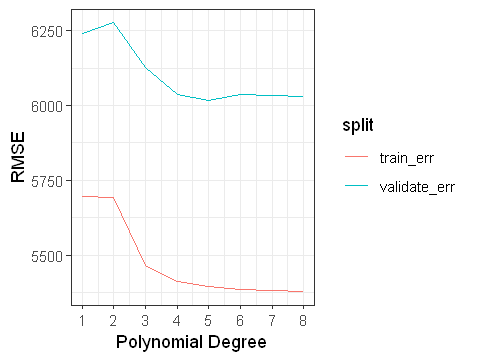

In [55]:
plot_data <- data.frame(K, train_err, validate_err) %>%
  gather("split", "error", -K)

ggplot(plot_data, aes(x=K, y=error, color=split)) +
  geom_line() +
  scale_x_continuous(breaks=K) +
  xlab('Polynomial Degree') +
  ylab('RMSE')

Although the training error decreases as we increase the degree, the test error bottoms out at for a fifth degree polynomial.

Let's re-fit this model on all of the data and plot the final result.

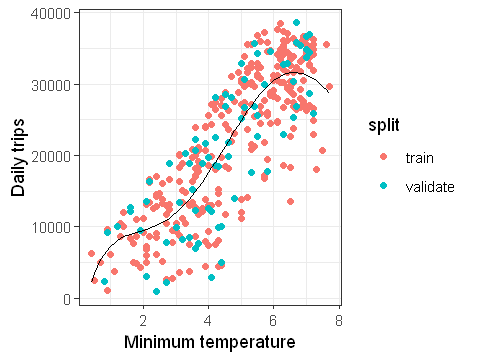

In [56]:
model <- lm(num_trips ~ poly(tmin, 5, raw = T), data = trips_per_day_train)

trips_per_day_train <- trips_per_day_train %>%
  add_predictions(model) %>%
  mutate(split = "train")
trips_per_day_validate <- trips_per_day_validate %>%
  add_predictions(model) %>%
  mutate(split = "validate")
plot_data <- bind_rows(trips_per_day_train, trips_per_day_validate)

ggplot(plot_data, aes(x = tmin, y = num_trips)) +
  geom_point(aes(color = split)) +
  geom_line(aes(y = pred)) +
  xlab('Minimum temperature') +
  ylab('Daily trips') +
  scale_y_continuous()

We're done at this point, with one important exception.

If we'd like to quote how well we expect this model to do on future data, we should use a final, held out test set that we touch only once to make this assessment.
(Reusing the validation set would give an optimistic estimate, as our modeling process has already seen that data in the cross-validation process.)

# K-fold cross-validation

The downside to a single train / validation split as done above is that when we don't have tons of data, we could get lucky (or unlucky) in terms of which rows end up in the training and validation sets.

k-fold cross-validation addresses this by first shuffling the data and then partitioning it into k "folds". The train / validation process is repeated, rotating through each fold as the validation data (and the rest as training data).
This allows us to get a more stable estimate of generalization error, as well as some idea of uncertainty in that estimate.

First we'll shuffle the data by sampling row numbers without replacement, then we'll assign each row to a fold.

In [145]:
RNGkind(sample.kind = "Rounding")
set.seed(42)
num_folds <- 5
num_days <- nrow(trips_per_day)

ndx <- sample(1:num_days, num_train, replace=F)

trips_per_day <- trips_per_day[ndx, ] %>%
  mutate(fold = (row_number() %% num_folds) + 1)

head(trips_per_day)

Warning message in RNGkind(sample.kind = "Rounding"):
"non-uniform 'Rounding' sampler used"

ymd,num_trips,date,prcp,snwd,snow,tmax,tmin,fold
2014-09-27,30463,20140927,0.00,0,0,8.3,6.0,2
2014-04-23,26949,20140423,0.00,0,0,6.1,4.4,3
2014-05-12,31644,20140512,0.00,0,0,8.5,6.4,4
2014-06-13,18308,20140613,1.28,0,0,7.9,6.5,5
2014-12-22,13120,20141222,0.04,0,0,4.4,3.5,1
2014-07-30,37377,20140730,0.00,0,0,8.0,6.3,2


Now we'll loop through each polynomial degree, as before, but add an inner loop over folds to compute the average validation error 

In [146]:
# fit a model for each polynomial degree
K <- 1:8
avg_validate_err <- c()
se_validate_err <- c()
for (k in K) {

  # do 5-fold cross-validation within each value of k
  validate_err <- c()
  for (f in 1:num_folds) {
    # fit on the training data
    trips_per_day_train <- filter(trips_per_day, fold != f)
    model <- lm(num_trips ~ poly(tmin, k, raw = T), data=trips_per_day_train)

    # evaluate on the validation data
    trips_per_day_validate <- filter(trips_per_day, fold == f)
    validate_err[f] <- sqrt(mean((predict(model, trips_per_day_validate) - trips_per_day_validate$num_trips)^2))
  }

  # compute the average validation error across folds
  # and the standard error on this estimate
  avg_validate_err[k] <- mean(validate_err)
  se_validate_err[k] <- sd(validate_err) / sqrt(num_folds)
}

And finally we'll plot the resulting average validation error as a function of polynomial degree.

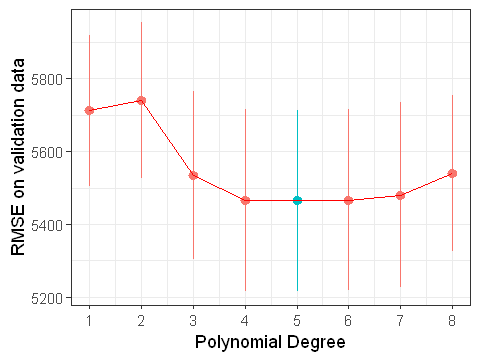

In [147]:
# plot the validate error, highlighting the value of k with the lowest average error
plot_data <- data.frame(K, avg_validate_err, se_validate_err)
ggplot(plot_data, aes(x=K, y=avg_validate_err)) +
  geom_pointrange(aes(ymin=avg_validate_err - se_validate_err,
                      ymax=avg_validate_err + se_validate_err,
                      color=avg_validate_err == min(avg_validate_err))) +
  geom_line(color = "red") +
  scale_x_continuous(breaks=1:12) +
  theme(legend.position="none") +
  xlab('Polynomial Degree') +
  ylab('RMSE on validation data')

Again, we see that a fifth degree polynomial is a reasonable choice, but we also see that there's a fair bit of uncertainty on our estimate.
The gains mostly come from using a third degree polynomial or above.